Este notebook trata-se de uma atividade de exercício do curso Profissão Ciência de Dados da EBAC.

O objetivo dessa atividade é demonstrar o conhecimento sobre transformação de espaço de dados através do método de análise de componentes principais (PCA).

# Classificação de Atividade Humana com PCA

Vamos trabalhar uma base de atividade humana disponibilizada pela a [UCI](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones), a qual fez um trabalho de tracing de movimentação do smartphone de 30 pessoas diferentes, quando faziam 6 tipos de atividades diferentes.

## Carregando as Bibliotecas

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Carregando as variáveis

In [59]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns") #Removing squeeze argument and applying squeeze method after read_csv
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns") #Removing squeeze argument and applying squeeze method after read_csv
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns") #Removing squeeze argument and applying squeeze method after read_csv
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

<ipython-input-59-b202733a65e5>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
<ipython-input-59-b202733a65e5>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
<ipython-input-59-b202733a65e5>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

Para essa atividade, pede-se para fzer uma análise a acerca da variância utilizando a o PCA para a base de treino orginal e para ela normalizada.

In [60]:
#Criando a base normalizada
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: user 519 ms, sys: 3.18 ms, total: 522 ms
Wall time: 525 ms


In [61]:
#Realizando o PCA para as duas bases
pca = PCA().fit(X_train)
pca_pad = PCA().fit(X_train_pad)

train = pca.transform(X_train)
train_pad = pca_pad.transform(X_train_pad)
test = pca.transform(X_test)
test_pad = pca_pad.transform(X_test_pad)

In [62]:
#Criandos os Data frames
n_componentes = train.shape[1]

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

df_train = pd.DataFrame(train, columns=nomes_pca)
df_train_pad = pd.DataFrame(train_pad, columns=nomes_pca)
df_test = pd.DataFrame(test, columns=nomes_pca)
df_test_pad = pd.DataFrame(test_pad, columns=nomes_pca)

Para fim de comparação, utilizaremos o critério de utilização para 90% da variância explicada

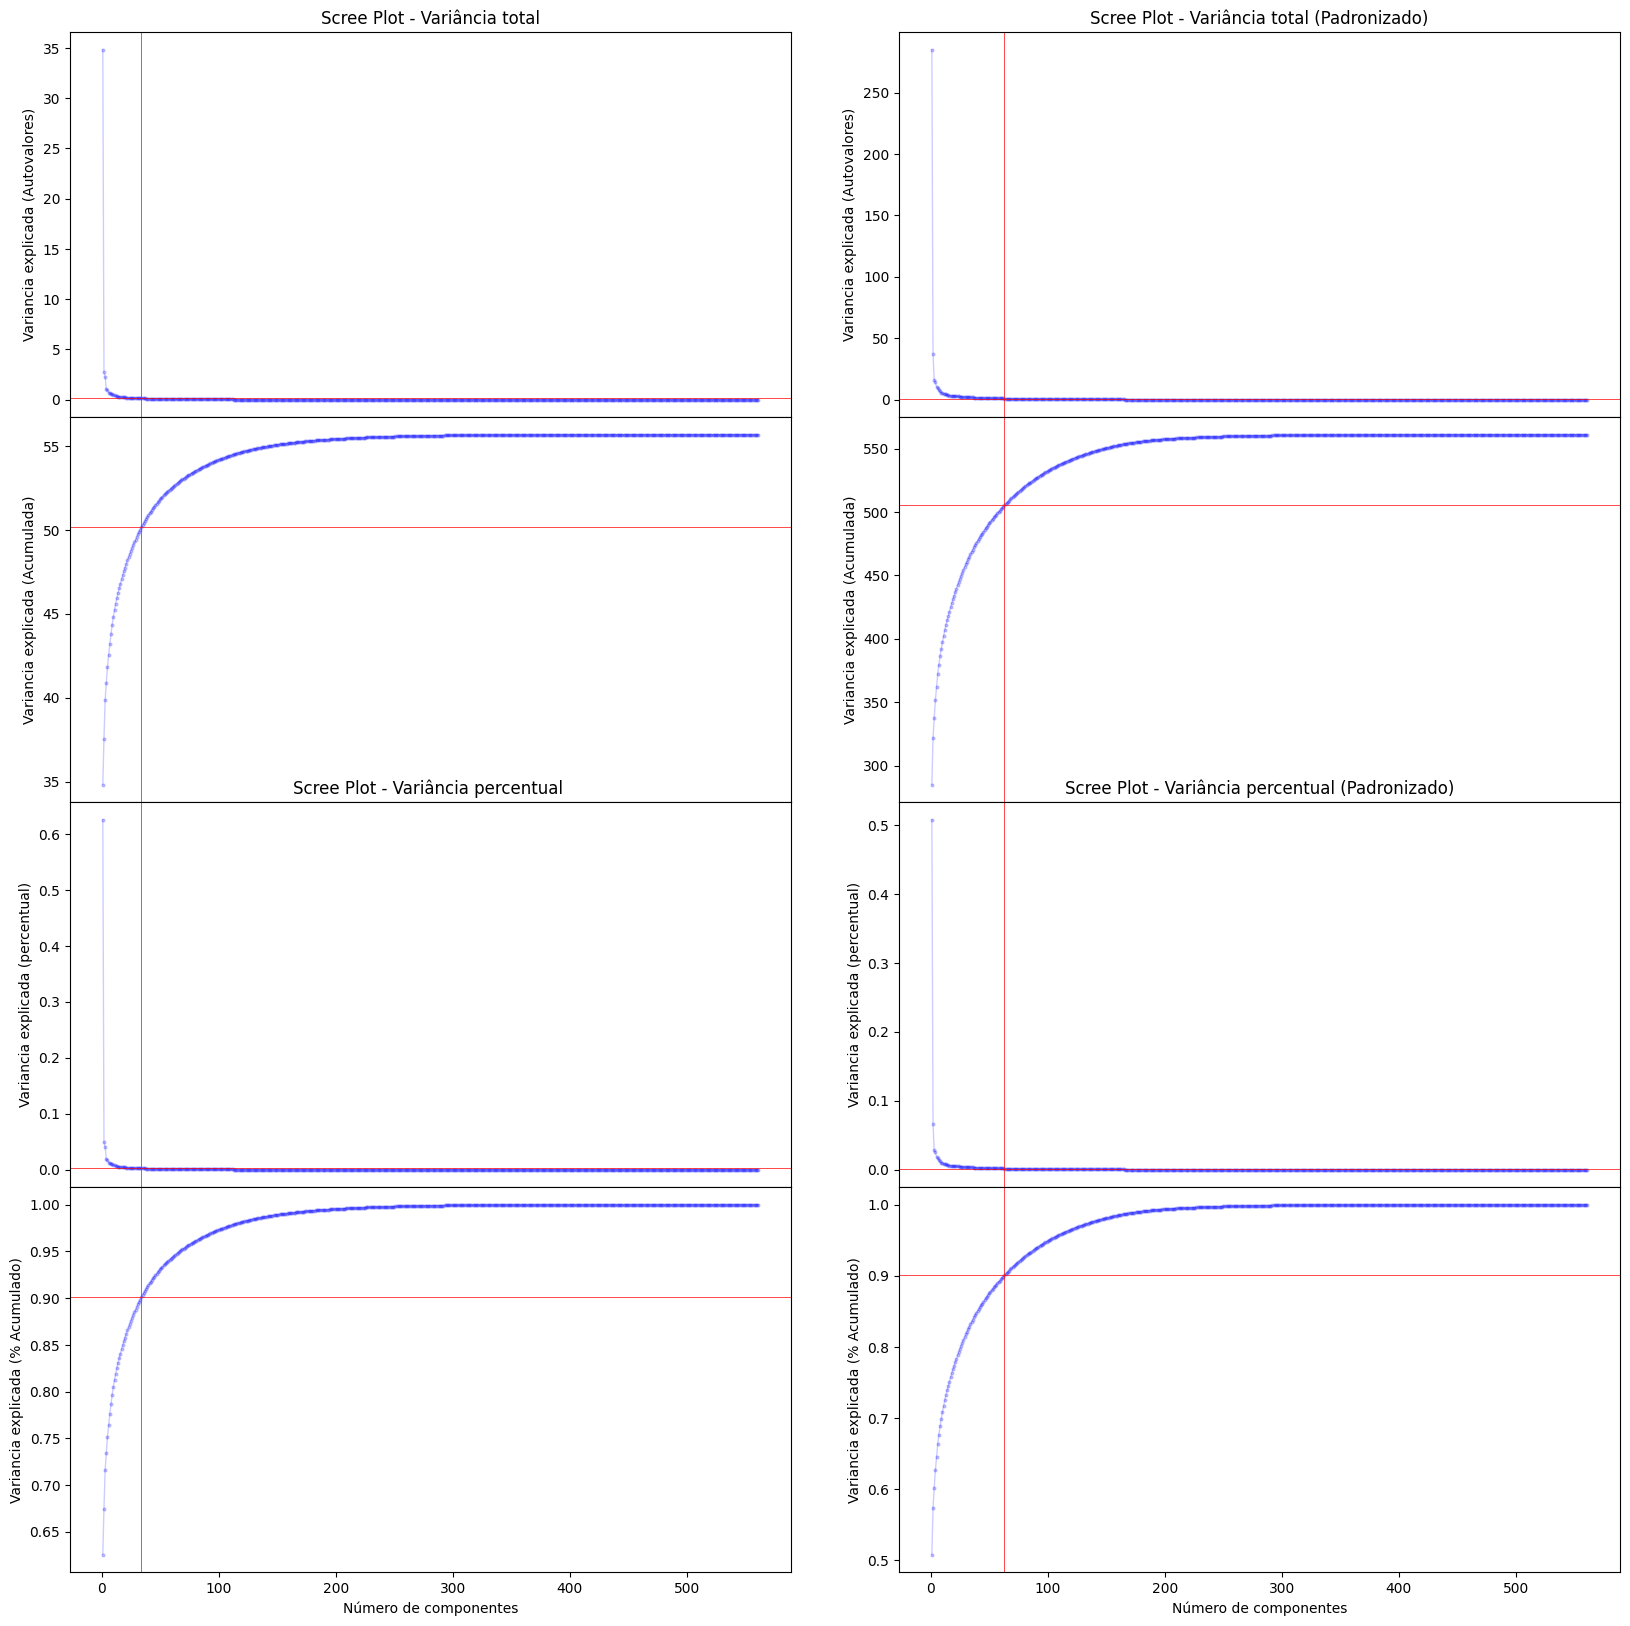

In [63]:
# Critério 3: % variância explicada

fig, ax = plt.subplots(4, 2, sharex=True, figsize=(20, 20))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .90
ncomp_criterio3 = (pca.explained_variance_ratio_.cumsum()<varexplicada).sum()+1
ncomp_criterio3_pad = (pca_pad.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(pca.n_components_) + 1
ax[0,0].plot(num_componentes, pca.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

num_componentes_pad = np.arange(pca_pad.n_components_) + 1
ax[0,1].plot(num_componentes_pad, pca_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância total (Padronizado)')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, pca.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

ax[1,1].plot(num_componentes_pad, pca_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[2,0].plot(num_componentes, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[2,0].set_title('Scree Plot - Variância percentual ')
ax[2,0].set_xlabel('Número de componentes')
ax[2,0].set_ylabel('Variancia explicada (percentual)')

ax[2,1].plot(num_componentes_pad, pca_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[2,1].set_title('Scree Plot - Variância percentual (Padronizado)')
ax[2,1].set_xlabel('Número de componentes')
ax[2,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[3,0].plot(num_componentes, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[3,0].set_xlabel('Número de componentes')
ax[3,0].set_ylabel('Variancia explicada (% Acumulado)')

ax[3,1].plot(num_componentes_pad, pca_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[3,1].set_xlabel('Número de componentes')
ax[3,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[2,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[2,1].axvline(x = ncomp_criterio3_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[3,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[3,1].axvline(x = ncomp_criterio3_pad, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = pca.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = pca_pad.explained_variance_[ncomp_criterio3_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = pca.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = pca_pad.explained_variance_.cumsum()[ncomp_criterio3_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[2,0].axhline(y = pca.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[2,1].axhline(y = pca_pad.explained_variance_ratio_[ncomp_criterio3_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[3,0].axhline(y = pca.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[3,1].axhline(y = pca_pad.explained_variance_ratio_.cumsum()[ncomp_criterio3_pad-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

Comparando os dois, com a base pradozinada foi exigida bem mais componentes para atingir 90% da variância explicada.

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [64]:
#Pegando as 10 primeiras colunas das nossas bases transformadas

df_train = df_train.iloc[:,:9]
df_test = df_test.iloc[:,:9]
df_train_pad = df_train_pad.iloc[:,:9]
df_test_pad = df_test_pad.iloc[:,:9]

### Base Original

In [65]:
%%time

clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf = clf.fit(df_train, y_train)

print(f'Acurácia na base de treino: {clf.score(df_train, y_train)*100:.1f}%')
print(f'Acurácia na base de teste: {clf.score(df_test, y_test)*100:.1f}%')

Acurácia na base de treino: 88.7%
Acurácia na base de teste: 80.4%
CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 142 ms


### Base Padronizada

In [66]:
%%time
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf = clf.fit(df_train_pad, y_train)

print(f'Acurácia na base de treino: {clf.score(df_train_pad, y_train)*100:.1f}%')
print(f'Acurácia na base de teste: {clf.score(df_test_pad, y_test)*100:.1f}%')

Acurácia na base de treino: 85.8%
Acurácia na base de teste: 77.9%
CPU times: user 131 ms, sys: 294 µs, total: 131 ms
Wall time: 132 ms


# **CONCLUSÃO**

A base padronizada, para os teste requeridos, se saiu pior. Pois, como vimos precisou de mais componentes para explicar 90% da variância dos dados do que a base normal, e quando rodamos uma árvore de decisão teve acurácia menor, tanto para a base de treino quanto para a base de teste.